# GridSearch Optimization

As we saw in the previous step we could notice that the Random Forest Regressor was the best model in our test split test. So now, we will use the optimization technique called Grid Search to tuning the best hyperparameters to our random forest regression model. The random forest regression has 6 parameters to set as maximum depth, maximum feature, minimum samples leaf, minimum samples split and the number of estimators.

The Grid Search works finding the less error changing each parameter and trying to find the best combination. It's a little bit more processor-intensive that Random Search, due it will be a combination about the every iteration that will define in the parameters.

But first, let's rebuild the first model without the tuning.

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
import datetime

In [2]:
def forecast_accuracy(predictions, test_labels):
    forecast = predictions
    actual = test_labels
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})


In [3]:
df_PS3Games = pd.read_csv('df_PS3Games.csv', sep = ',')
X = df_PS3Games[['Dayofweek','GDP','IMOEX','RubinDolar']]
y = df_PS3Games['Invoice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=0)
range = df_PS3Games.Date
df=pd.DataFrame(index = df_PS3Games.Date)

In [4]:
regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reduce_dim', PCA()),
        ('regressor', regr)
        ])
pipe.fit(X_train,y_train)
ypipe=pipe.predict(X_test)

C:\Users\Anthony\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Anthony\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Anthony\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [5]:
y_train = y_train.reset_index()
del y_train['index']
y_trainValue = y_train['Invoice'].values
y_test = y_test.reset_index()
del y_test['index']
y_testValue = y_test['Invoice'].values

In [6]:
predictions_series = pd.Series(ypipe, index=df.index[728:])
train_series = pd.Series(y_trainValue, index=df.index[:728])
test_series = pd.Series(y_testValue, index=df.index[728:])
## Convert index to datetime
predictions_series.index = pd.to_datetime(predictions_series.index)
train_series.index = pd.to_datetime(train_series.index)
test_series.index = pd.to_datetime(test_series.index)

C:\Users\Anthony\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


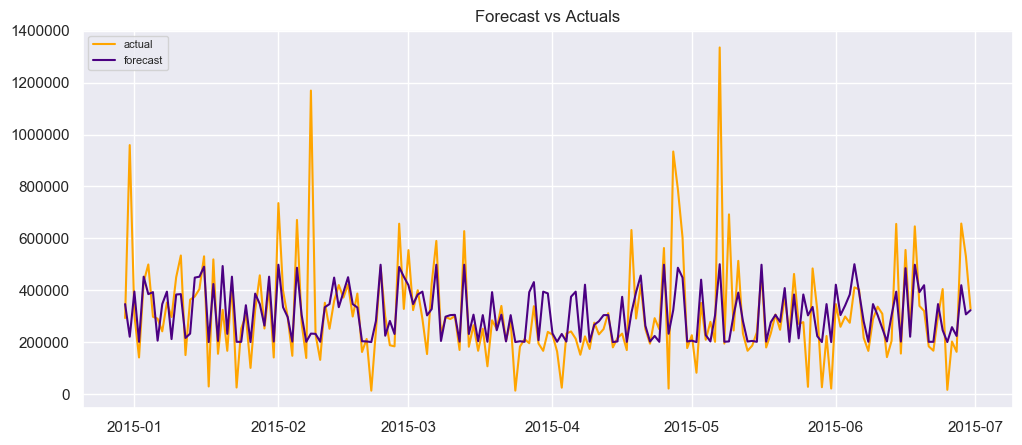

In [7]:
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train_labels, label='training')
plt.plot(test_series, label='actual',color ='orange')
plt.plot(predictions_series, label='forecast', color = 'indigo')
#plt.fill_between(train_labels.index, train_labels, test_labels, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [8]:
# Metrics
forecast_accuracy(predictions_series, test_series)

{'mape': 0.7722359273043331,
 'me': -1496.1138627774365,
 'mae': 95585.61212025365,
 'mpe': 0.6100347851145763,
 'rmse': 158111.35418950065,
 'corr': 0.5842659399650348,
 'minmax': 0.24744390833388796}

# Hyperparameter Optimization with Grid Search

We need to choose the points about each hyperparameter to build our grid, for each combination will be generated a error, tuning the hyperparameter means get the lesser error or the greater pearson correlation.

In [9]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50,100,150, 200,250, 300, 500, 1000],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5, 6, 7, 9],
    'min_samples_split': [10,20,30,40,50,100,200],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700,800,900, 1000, 1100, 1500, 2000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [10]:
# # Fit the grid search to the data                     ##
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

Then after 2 and half hours running the Grid Search algorithm in my potato notebook (8 GB Ram, i7 6th Gen, Hard Disk) we could find our best parameters:

 'bootstrap': True,
 'max_depth': 1000,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 100
 
 Now we can creating our Random Forest Regressor Model tuned.
 
 *If you want to execute the grid search, just uncomment the previous cell and execute.

In [10]:
regr = RandomForestRegressor(random_state = 100,bootstrap = True, max_depth=1000,max_features=2,min_samples_leaf=3,min_samples_split=10,n_estimators=100)
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reduce_dim', PCA()),
        ('regressor', regr)
        ])
pipe.fit(X_train,y_train)
ypipe=pipe.predict(X_test)

C:\Users\Anthony\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Anthony\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Anthony\Anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Users\Anthony\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [11]:
y_train = y_train.reset_index()
del y_train['index']
y_trainValue = y_train['Invoice'].values
y_test = y_test.reset_index()
del y_test['index']
y_testValue = y_test['Invoice'].values

In [12]:
predictions_series = pd.Series(ypipe, index=df.index[728:])
train_series = pd.Series(y_trainValue, index=df.index[:728])
test_series = pd.Series(y_testValue, index=df.index[728:])
## Convert index to datetime
predictions_series.index = pd.to_datetime(predictions_series.index)
train_series.index = pd.to_datetime(train_series.index)
test_series.index = pd.to_datetime(test_series.index)

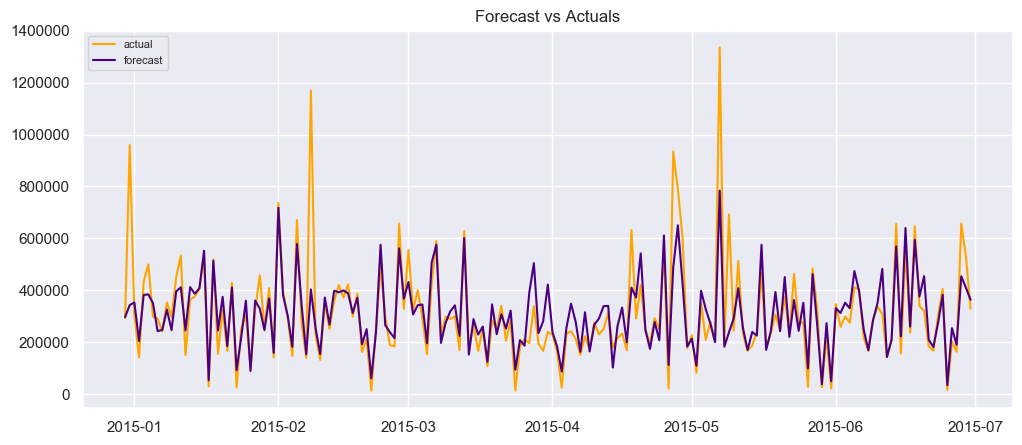

In [13]:
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train_labels, label='training')
plt.plot(test_series, label='actual',color ='orange')
plt.plot(predictions_series, label='forecast', color = 'indigo')
#plt.fill_between(train_labels.index, train_labels, test_labels, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [14]:
# Metrics
forecast_accuracy(predictions_series, test_series)

{'mape': 0.30867549774628983,
 'me': -1969.3988090582145,
 'mae': 62860.269763640856,
 'mpe': 0.19683883537762803,
 'rmse': 115274.98738815413,
 'corr': 0.8117920852059032,
 'minmax': 0.17832525870071558}

We found 0.81 with the Pearson Correlation, this means a strong correlation with the real data. Thus it can be pass to the next step, if it wasn't only to play, the deploy of the model.

For a better test of our model, we could split the dataset in Train, Hold out, Test, where that would make it possible a better understanding about our model, like how the model behaves with more recent data.

Perhaps it can be a next step in this little project. :D

To finish we will see the bar of importance for each exogenous variables and plot one decision tree in our forest.

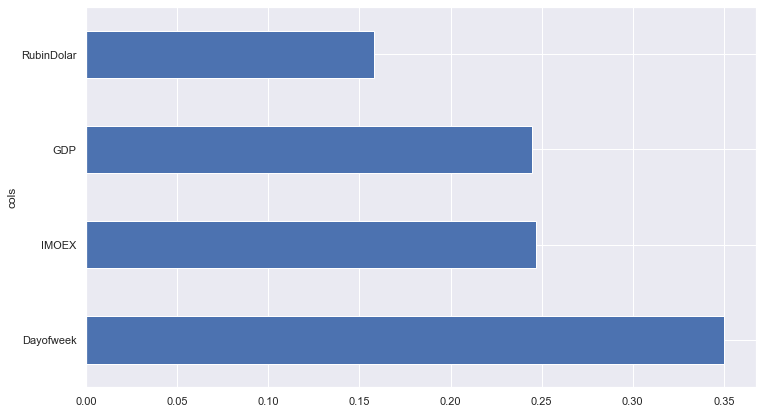

In [15]:
from fastai.imports import*
from fastai.structured import *
fi = rf_feat_importance(regr, X)
fi.imp.sum()
def plot_fi(fi):
    return fi.plot('cols','imp','barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

# The first Decision Tree in our forest

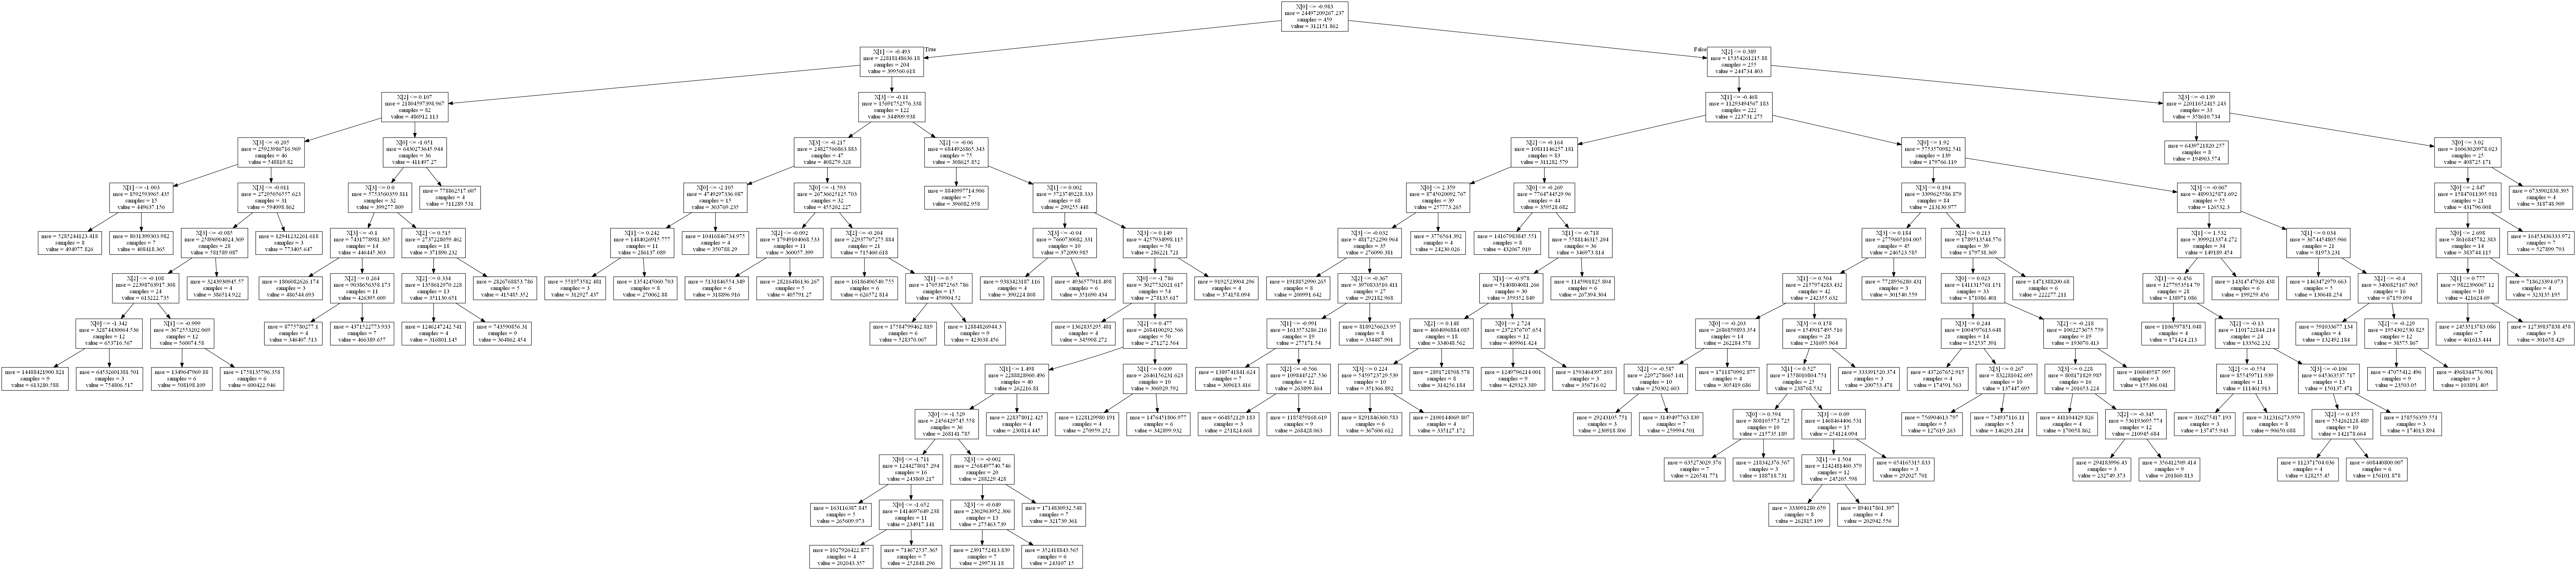

In [16]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

import os
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

dot_data = StringIO()
export_graphviz(pipe.named_steps['regressor'].estimators_[0], out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())